In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, 
                                     Dropout,Bidirectional, LSTM , MaxPooling2D , Reshape)
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras import backend as k
from tensorflow.keras.optimizers import Adam , SGD 
from tensorflow.keras.callbacks import  ReduceLROnPlateau 
from tensorflow.keras.regularizers  import L2
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K 
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.preprocessing.image import img_to_array, load_img


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
mat_path = "/kaggle/input/street-view-house-numbers/train_digitStruct.mat"
test_mat_path = "/kaggle/input/street-view-house-numbers/test_digitStruct.mat"
img_path  ="/kaggle/input/street-view-house-numbers/train/train/"
test_img_path = "/kaggle/input/street-view-house-numbers/test/test/"

In [3]:
!pip install mat73

  Obtaining dependency information for mat73 from https://files.pythonhosted.org/packages/d4/c3/123c118e31cd58f5db333ae2750da13da0d87707adac2255357de9bb5f87/mat73-0.62-py3-none-any.whl.metadata


In [4]:
import mat73
data = mat73.loadmat(mat_path)

In [5]:
test_data = mat73.loadmat(test_mat_path)

In [6]:
def convert_to_list(value):
    if not isinstance(value, list):
        return [value]
    return value

In [7]:
char_list =['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [8]:
def to_DataFrame(mat_data , image_path):
    height = []
    labels = []
    left = []
    top = []
    width = []
    img_name = [image_path+name for name in mat_data["digitStruct"]["name"]]
    for item in mat_data["digitStruct"]["bbox"]:
        height.append(item['height'])
        labels.append(item['label'])
        left.append(item['left'])
        top.append(item['top'])
        width.append(item['width'])
    labels = [convert_to_list(item) for item in labels]
    max_label_len = max([len(text) for text in labels])
    height = [convert_to_list(item) for item in height]
    width = [convert_to_list(item) for item in width]
    top = [convert_to_list(item) for item in top]
    left = [convert_to_list(item) for item in left]
    labels = [[int(item)%10 for item in label] for label in labels]
    labels = [pad_sequences([label], maxlen=6, padding='post' ,value = len(char_list))[0] for label in labels]
    Dataframe = pd.DataFrame({"img_path":img_name ,'height': height, 'label': labels, 'left': left, 'top': top, 'width': width})
    
    return Dataframe

In [9]:
Dataframe = to_DataFrame(data , img_path)
test_df = to_DataFrame(test_data , test_img_path)

In [10]:
from sklearn.model_selection import train_test_split
train_df , val_df = train_test_split(Dataframe , test_size = 0.2)

In [11]:
train_df.head()

img_path        height  \
21151  /kaggle/input/street-view-house-numbers/train/...  [28.0, 28.0]   
32848  /kaggle/input/street-view-house-numbers/train/...  [50.0, 50.0]   
26230  /kaggle/input/street-view-house-numbers/train/...  [64.0, 64.0]   
22429  /kaggle/input/street-view-house-numbers/train/...        [15.0]   
16909  /kaggle/input/street-view-house-numbers/train/...        [48.0]   

                         label            left           top         width  
21151   [2, 2, 10, 10, 10, 10]    [46.0, 64.0]   [11.0, 7.0]  [16.0, 16.0]  
32848   [3, 4, 10, 10, 10, 10]    [58.0, 83.0]  [13.0, 15.0]  [32.0, 35.0]  
26230   [3, 1, 10, 10, 10, 10]  [120.0, 153.0]  [26.0, 38.0]  [42.0, 36.0]  
22429  [1, 10, 10, 10, 10, 10]          [15.0]         [1.0]         [6.0]  
16909  [1, 10, 10, 10, 10, 10]          [53.0]        [11.0]        [13.0]

In [12]:
test_df.head()

img_path              height  \
0  /kaggle/input/street-view-house-numbers/test/t...              [30.0]   
1  /kaggle/input/street-view-house-numbers/test/t...  [23.0, 23.0, 23.0]   
2  /kaggle/input/street-view-house-numbers/test/t...              [16.0]   
3  /kaggle/input/street-view-house-numbers/test/t...              [17.0]   
4  /kaggle/input/street-view-house-numbers/test/t...              [28.0]   

                     label                  left              top  \
0  [5, 10, 10, 10, 10, 10]                [43.0]            [7.0]   
1    [2, 1, 0, 10, 10, 10]  [99.0, 114.0, 121.0]  [5.0, 8.0, 6.0]   
2  [6, 10, 10, 10, 10, 10]                [61.0]            [6.0]   
3  [1, 10, 10, 10, 10, 10]                [32.0]            [6.0]   
4  [9, 10, 10, 10, 10, 10]                [97.0]           [28.0]   

               width  
0             [19.0]  
1  [14.0, 8.0, 12.0]  
2             [11.0]  
3             [14.0]  
4             [19.0]

[array([ 6,  1,  8, 10, 10, 10], dtype=int32)]


(-0.5, 179.5, 67.5, -0.5)

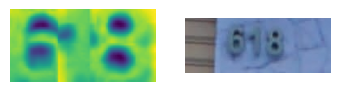

In [13]:
import math
row = train_df.iloc[4574]
img  = cv2.imread(row["img_path"])
top_list = row['top']
left_list = row['left']
height_list = row['height']
width_list = row['width']
label_list = row['label']

concatenated_roi = None
labels = []
preprocessed_images = []

common_height = 32  # Set a common height for all ROIs

for i in range(len(top_list)):
    top = abs(top_list[i])
    left = abs(left_list[i])
    height = abs(height_list[i])
    width = abs(width_list[i])

    object_roi = img[int(top):int(top + height), int(left):int(left + width)]

    # Resize each ROI to the common height
    resized_object_roi = cv2.resize(object_roi, (int(width / height * common_height), common_height))

    if concatenated_roi is None:
        concatenated_roi = resized_object_roi
    else:
        concatenated_roi = np.concatenate((concatenated_roi, resized_object_roi), axis=1)

labels.append(label_list)

resized_concatenated_roi = cv2.resize(concatenated_roi, (64, 32))
grayscale_concatenated_roi = cv2.cvtColor(resized_concatenated_roi, cv2.COLOR_BGR2GRAY)

preprocessed_images.append(grayscale_concatenated_roi)


print(labels)
plt.subplot(1 , 3,1)
plt.imshow(preprocessed_images[0])
plt.axis("off")
plt.subplot(1 , 3,2)
plt.imshow(img)
plt.axis("off")
plt.axis("off")


In [14]:
import cv2
import numpy as np

def preprocess_and_extract_roi(row):
    img = cv2.imread(row['img_path'])
    if img is None:
        return None, None

    top_list = row['top']
    left_list = row['left']
    height_list = row['height']
    width_list = row['width']
    label_list = row['label']

    concatenated_roi = None
    labels = []
    preprocessed_images = []

    common_height = 32  # Set a common height for all ROIs

    for i in range(len(top_list)):
        top = abs(top_list[i])
        left = abs(left_list[i])
        height = abs(height_list[i])
        width = abs(width_list[i])

        object_roi = img[int(top):int(top + height), int(left):int(left + width)]

        # Resize each ROI to the common height
        resized_object_roi = cv2.resize(object_roi, (int(width / height * common_height), common_height))

        if concatenated_roi is None:
            concatenated_roi = resized_object_roi
        else:
            concatenated_roi = np.concatenate((concatenated_roi, resized_object_roi), axis=1)

    labels.append(label_list)

    resized_concatenated_roi = cv2.resize(concatenated_roi, (64, 32))
    grayscale_concatenated_roi = cv2.cvtColor(resized_concatenated_roi, cv2.COLOR_BGR2GRAY)

    preprocessed_images.append(grayscale_concatenated_roi)

    return preprocessed_images, labels


In [15]:
def preprocess_and_extract_roi_batch(dataframe):
    preprocessed_images = []
    labels = []

    for index, row in dataframe.iterrows():
        images, lbls = preprocess_and_extract_roi(row)
        if images is not None and lbls is not None:
            preprocessed_images.extend(images)
            labels.extend(lbls)

    return preprocessed_images, labels

In [16]:
train_preprocessed_images, train_labels = preprocess_and_extract_roi_batch(train_df)
train_preprocessed_images = np.array(train_preprocessed_images)
train_labels = np.array(train_labels)

test_preprocessed_images, test_labels = preprocess_and_extract_roi_batch(test_df)
test_preprocessed_images = np.array(test_preprocessed_images)
test_labels = np.array(test_labels)

In [17]:
val_preprocessed_images, val_labels = preprocess_and_extract_roi_batch(val_df)
val_preprocessed_images = np.array(val_preprocessed_images)
val_labels = np.array(val_labels)

/opt/conda/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


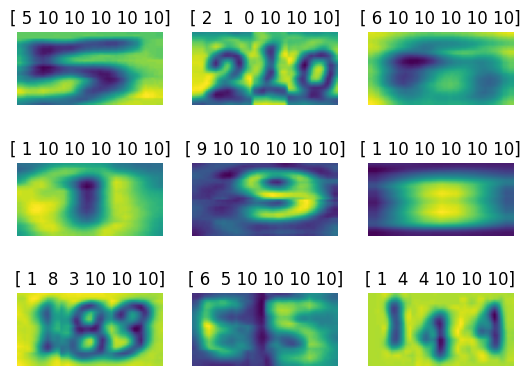

In [18]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(test_preprocessed_images[i])
    plt.axis("off")
    plt.title(test_labels[i])

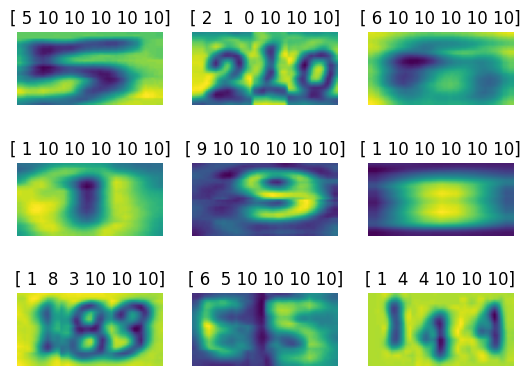

In [19]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(test_preprocessed_images[i])
    plt.axis("off")
    plt.title(test_labels[i])

In [20]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_preprocessed_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_preprocessed_images, test_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_preprocessed_images, val_labels))

In [21]:
def process_single_sample(img, label):
    return {"image": img, "label": label}

In [22]:
batch_size = 64
train_dataset = (train_dataset
                 .map(process_single_sample)
                 .batch(batch_size))
val_dataset = (val_dataset
                 .map(process_single_sample)
                 .batch(batch_size))
test_dataset = (test_dataset
                .map(process_single_sample)
                .batch(batch_size))

In [23]:
from itertools import groupby
def ctc_decoder(predictions):
    '''
    input: given batch of predictions from text rec model
    output: return lists of raw extracted text

    '''
    text_list = []
    
    pred_indcies = np.argmax(predictions, axis=-1)
    
    for i in range(pred_indcies.shape[0]):
        ans = ""
        
        ## merge repeats
        merged_list = [k for k,_ in groupby(pred_indcies[i])]
        
        ## remove blanks
        for p in merged_list:
            if p != len(char_list):
                ans += char_list[int(p)]
        
        text_list.append(ans)
        
    return text_list



In [24]:
def ctc_accuracy(y_pred , y_true):
    pred_text = ctc_decoder(y_pred)
    org_text = []
    for i in range(len(y_true)):
        ans=""
        for p in y_true[i]:
            if p != 10:
                ans += str(p)
        org_text.append(ans)
    correct_predictions = sum([1 for pred, true in zip(pred_text, org_text) if pred == true])
    total_samples = len(y_pred)
    accuracy = correct_predictions / total_samples if total_samples > 0 else 0.0

        # Optionally, you can use tf.print to print the accuracy during training
    tf.print("CTC Accuracy:", accuracy)

In [25]:
figures_list = []

class PlotPredictions(tf.keras.callbacks.Callback):

    def __init__(self, frequency=1):
        self.frequency = frequency
        super(PlotPredictions, self).__init__()

        batch = test_dataset.take(7)
        self.batch_images = list(batch.as_numpy_iterator())[0]["image"]
        self.batch_labels = list(batch.as_numpy_iterator())[0]["label"]

    def plot_predictions(self, epoch):

        prediction_model = keras.models.Model(
            self.model.get_layer(name="image").input, 
            self.model.get_layer(name="dense").output
        )
        
        preds = prediction_model.predict(self.batch_images)
        pred_texts = ctc_decoder(preds)
        

        orig_texts = []

        for label in self.batch_labels:
            orig_texts.append("".join([char_list[int(char_ind)] for char_ind in label if not(char_ind == len(char_list))]))

        fig , ax = plt.subplots(4, 4, figsize=(15, 5))
        fig.suptitle('Epoch: '+str(epoch), weight='bold', size=14)

        for i in range(16):

            img = (self.batch_images[i, :, :] * 255).astype(np.uint8)
            title = f"Prediction: {pred_texts[i]}"
            ax[i // 4, i % 4].imshow(img, cmap="gray")
            ax[i // 4, i % 4].set_title(title)
            ax[i // 4, i % 4].axis("off")
        
        plt.show()

        figures_list.append(fig)

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:
            self.plot_predictions(epoch)

In [26]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.512, patience=3, min_delta=0.0001, cooldown=2, verbose=1)

In [27]:
class CTCLayer(layers.Layer):

    def __init__(self, name=None):

        super().__init__(name=name)
        self.loss_fn = K.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.

        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [39]:
inputs = Input(shape=(32, 64, 1) , name = "image")
labels = layers.Input(name="label", shape=(None,), dtype="float32")

x = Conv2D(32, (4,4), kernel_initializer="he_uniform", padding='same', activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2, 1))(x)

x = Conv2D(64, (2, 3), padding='same', activation='relu')(x)
# x = Dropout(0.2)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, (2, 3), padding='same', activation='relu')(x)
# x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 1))(x)


x = Conv2D(256, (2,3),padding='same', activation='relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 1))(x)

conv_6 = Conv2D(32, (2,2), activation = "relu")(x)
x = Dropout(0.2)(x)

squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_6)

# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(256, return_sequences=True , dropout=0.25))(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True))(blstm_1)

softmax_output = Dense(len(char_list)+1, activation = 'softmax', name="dense")(blstm_2)

output = CTCLayer(name="ctc_loss")(labels, softmax_output)
optimizer = Adam(lr=0.001 ,beta_1=0.9, beta_2=0.99, clipnorm=1.0)

#model to be used at training time
model = Model(inputs=[inputs, labels], outputs=output)
model.compile(optimizer = optimizer)
model.summary()

Model: "model_32"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 32, 64, 1)]          0         []                            
                                                                                                  
 conv2d_5 (Conv2D)           (None, 32, 64, 32)           544       ['image[0][0]']               
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 16, 64, 32)           0         ['conv2d_5[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_6 (Conv2D)           (None, 16, 64, 64)           12352     ['max_pooling2d_4[0][0]

In [29]:
# inputs = Input(shape=(32, 64, 1), name="image")

# labels = layers.Input(name="label", shape=(None,), dtype="float32")

# conv_1 = Conv2D(32, (2,3), activation = "relu" , padding='same' )(inputs)
# pool_1 = MaxPool2D(pool_size=(2, 1))(conv_1)
# batch_norm_1 = BatchNormalization()(pool_1)

# conv_2 = Conv2D(64, (2,3), activation = "relu", padding='same')(batch_norm_1)
# pool_2 = MaxPool2D(pool_size=(2, 1))(conv_2)
# batch_norm_2 = BatchNormalization()(pool_2)

# conv_3 = Conv2D(64, (2,3), activation = "relu", padding='same')(batch_norm_2)
# d_3 = Dropout(0.1)(conv_3)
# pool_3 = MaxPool2D(pool_size=(2, 1))(d_3)
# batch_norm_3 = BatchNormalization()(pool_3)

# conv_4 = Conv2D(128, (2,3), activation = "relu", padding='same')(d_3)
# d_4 = Dropout(0.1)(conv_4)
# pool_4 = MaxPool2D(pool_size=(2, 2))(d_4)


# conv_5 = Conv2D(256, (2,3), activation = "relu", padding='same')(pool_4)
# pool_5 = MaxPool2D(pool_size=(2, 1))(conv_5)
# batch_norm_5 = BatchNormalization()(pool_5)


# conv_6 = Conv2D(11, (2,2), activation = "relu")(batch_norm_5)

# squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_6)

# # bidirectional LSTM layers with units=128
# blstm_1 = Bidirectional(LSTM(256, return_sequences=True , dropout=0.25))(squeezed)
# blstm_2 = Bidirectional(LSTM(128, return_sequences=True))(blstm_1)

# softmax_output = Dense(len(char_list)+1, activation = 'softmax', name="dense")(blstm_2)

# output = CTCLayer(name="ctc_loss")(labels, softmax_output)
# optimizer = Adam(lr=0.001 ,beta_1=0.9, beta_2=0.99, clipnorm=1.0)

# #model to be used at training time
# model = Model(inputs=[inputs, labels], outputs=output)
# model.compile(optimizer = optimizer)
# model.summary()

In [40]:
callbacks_list = [PlotPredictions(frequency=1),
                  reduce_lr]

Epoch 1/30


2024-01-19 08:16:17.930971: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_32/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2/2 [==============================] - 1s 8ms/step - loss: 4.32


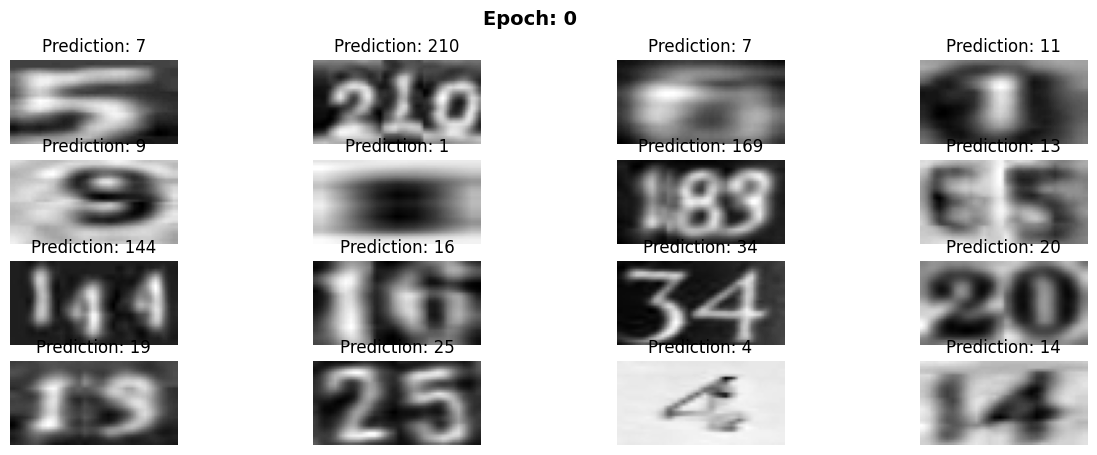

418/418 [==============================] - 37s 65ms/step - loss: 4.3250 - val_loss: 2.3980 - lr: 0.0010
Epoch 2/30
2/2 [==============================] - 1s 7ms/step - loss: 1.50


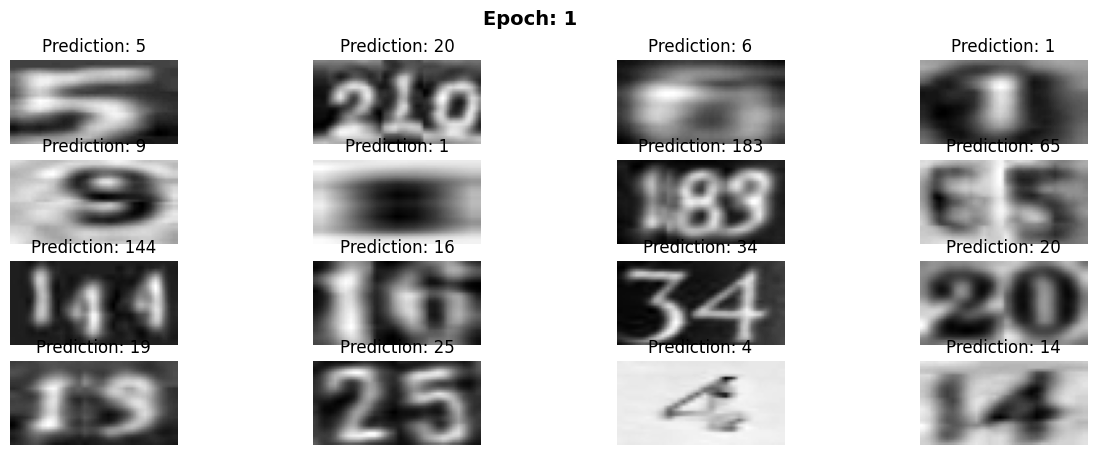

418/418 [==============================] - 25s 60ms/step - loss: 1.5062 - val_loss: 1.2166 - lr: 0.0010
Epoch 3/30
2/2 [==============================] - 1s 7ms/step - loss: 1.08


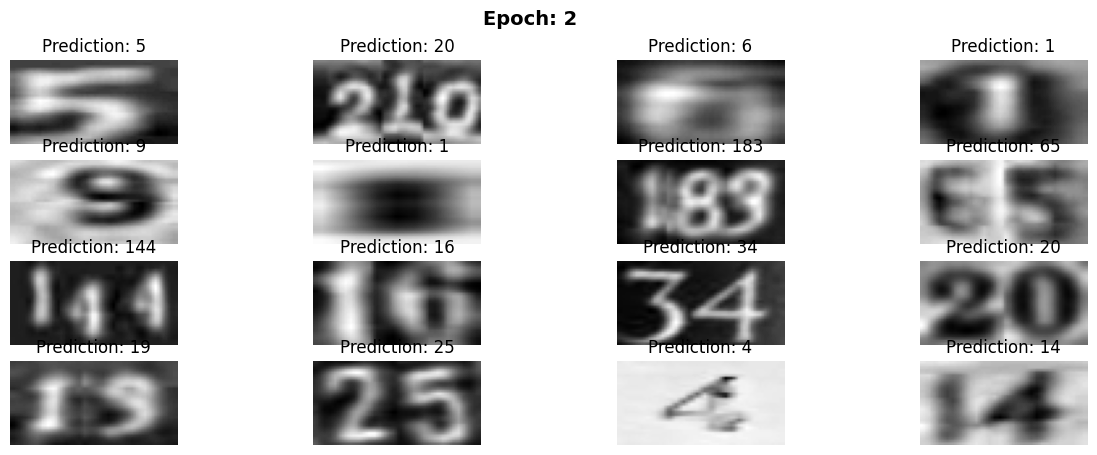

418/418 [==============================] - 26s 63ms/step - loss: 1.0808 - val_loss: 1.0457 - lr: 0.0010
Epoch 4/30
2/2 [==============================] - 1s 7ms/step - loss: 0.90


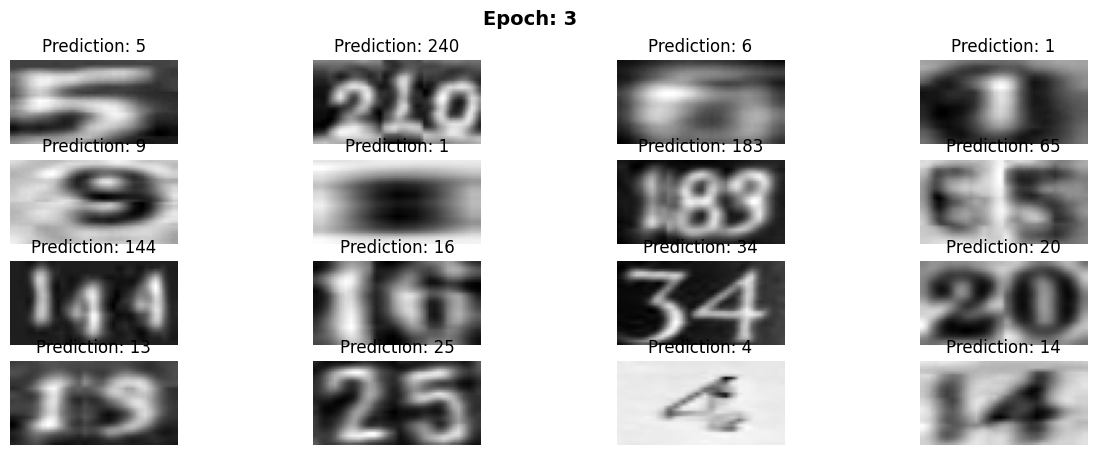

418/418 [==============================] - 25s 60ms/step - loss: 0.9006 - val_loss: 0.9834 - lr: 0.0010
Epoch 5/30
2/2 [==============================] - 1s 7ms/step - loss: 0.79


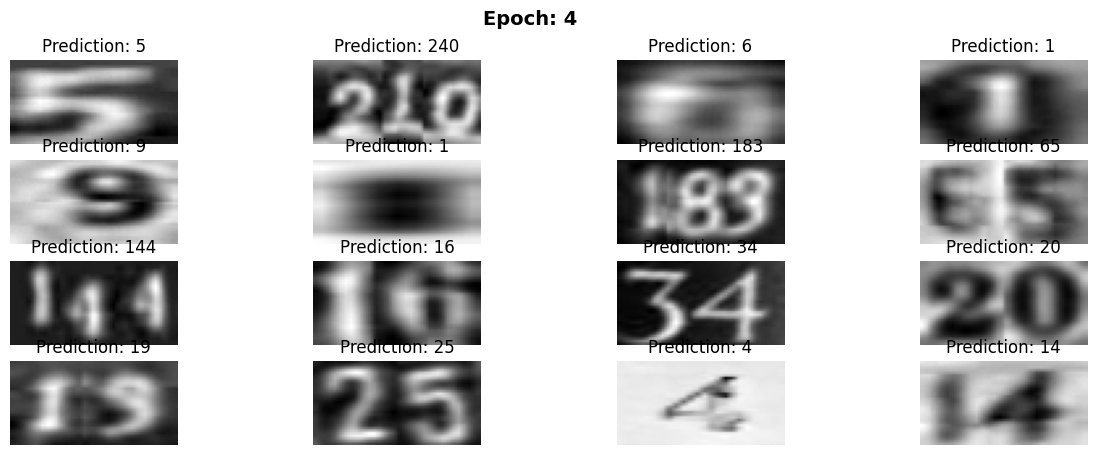

418/418 [==============================] - 25s 60ms/step - loss: 0.7974 - val_loss: 0.8348 - lr: 0.0010
Epoch 6/30
2/2 [==============================] - 1s 7ms/step - loss: 0.70


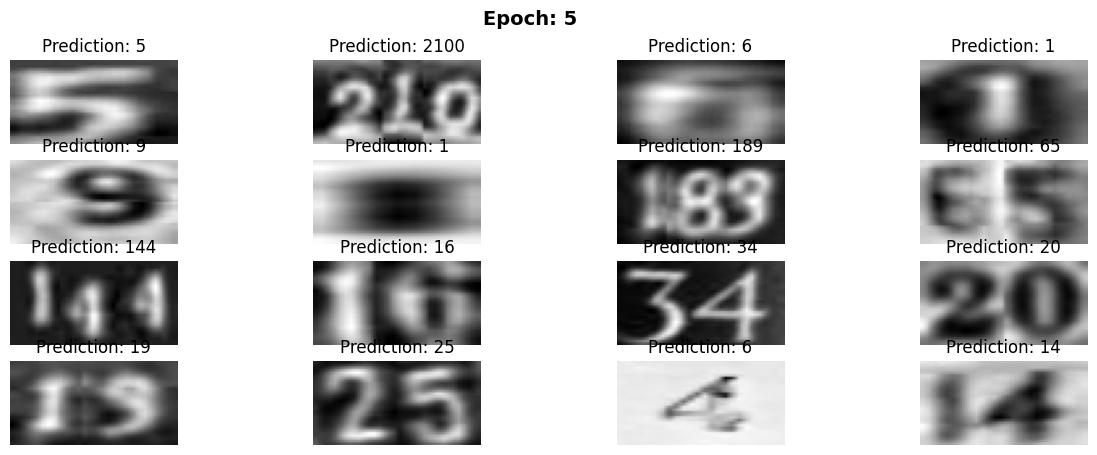

418/418 [==============================] - 25s 60ms/step - loss: 0.7014 - val_loss: 0.8506 - lr: 0.0010
Epoch 7/30
2/2 [==============================] - 1s 7ms/step - loss: 0.64


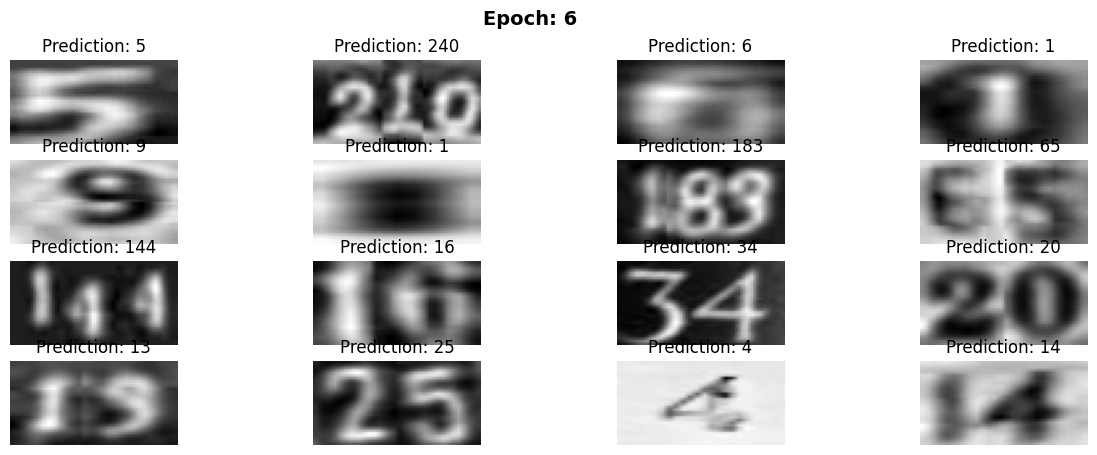

418/418 [==============================] - 25s 60ms/step - loss: 0.6401 - val_loss: 0.7916 - lr: 0.0010
Epoch 8/30
2/2 [==============================] - 1s 8ms/step - loss: 0.58


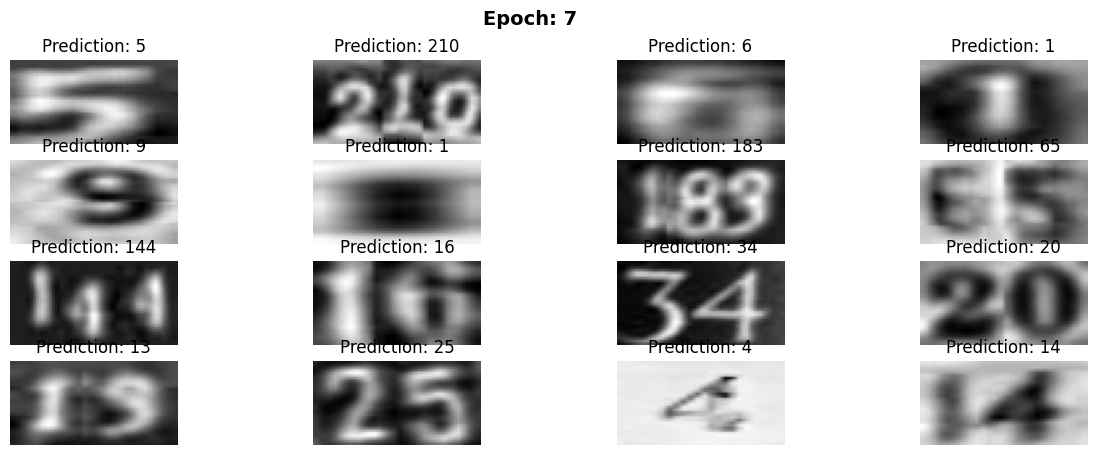

418/418 [==============================] - 25s 59ms/step - loss: 0.5858 - val_loss: 0.8275 - lr: 0.0010
Epoch 9/30
2/2 [==============================] - 1s 7ms/step - loss: 0.54


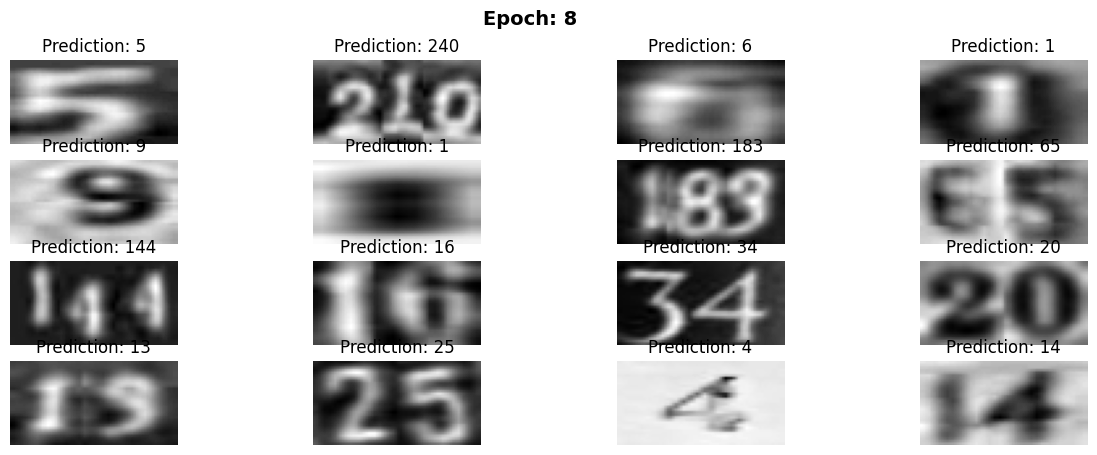

418/418 [==============================] - 25s 60ms/step - loss: 0.5420 - val_loss: 0.7721 - lr: 0.0010
Epoch 10/30
2/2 [==============================] - 1s 7ms/step - loss: 0.50


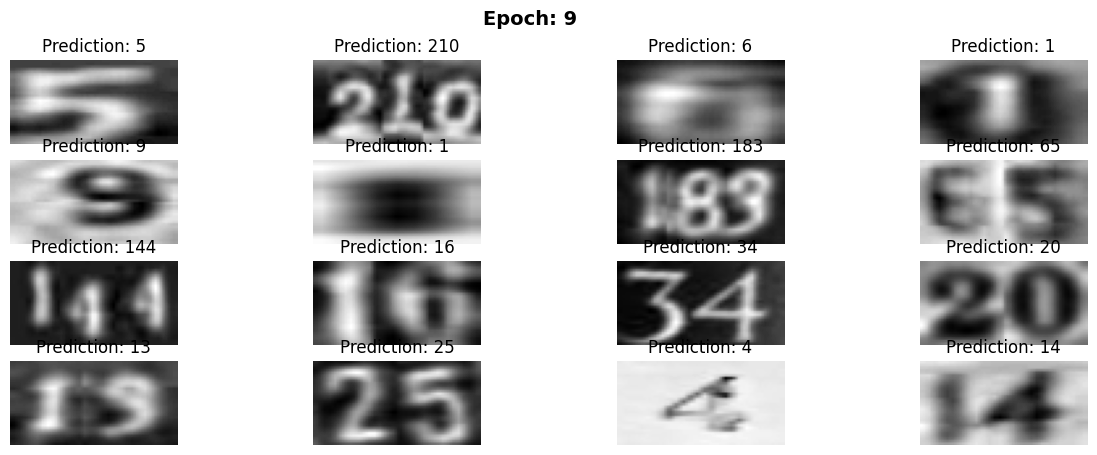

418/418 [==============================] - 25s 60ms/step - loss: 0.5056 - val_loss: 0.7759 - lr: 0.0010
Epoch 11/30
2/2 [==============================] - 1s 7ms/step - loss: 0.46


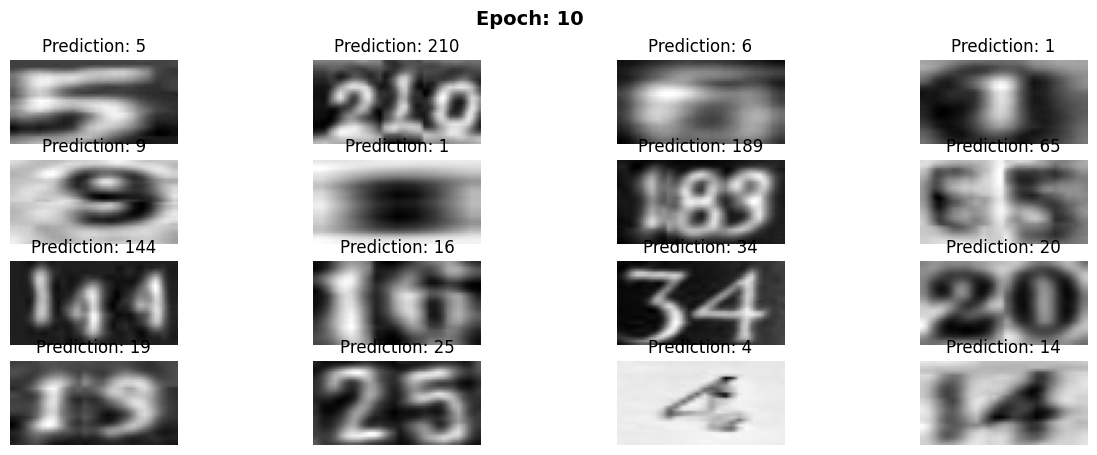

418/418 [==============================] - 25s 60ms/step - loss: 0.4653 - val_loss: 0.7744 - lr: 0.0010
Epoch 12/30
2/2 [==============================] - 1s 7ms/step - loss: 0.43


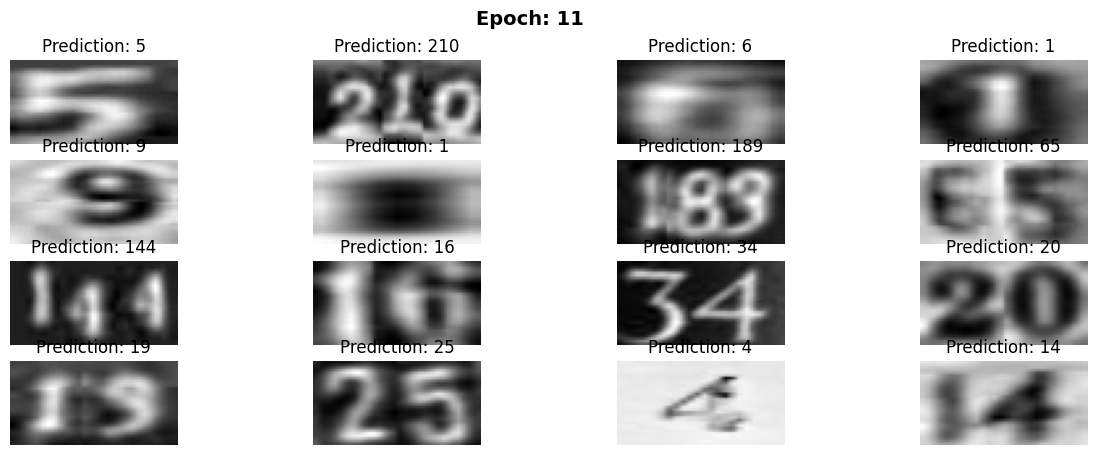

418/418 [==============================] - 25s 60ms/step - loss: 0.4377 - val_loss: 0.7672 - lr: 0.0010
Epoch 13/30
2/2 [==============================] - 1s 8ms/step - loss: 0.41


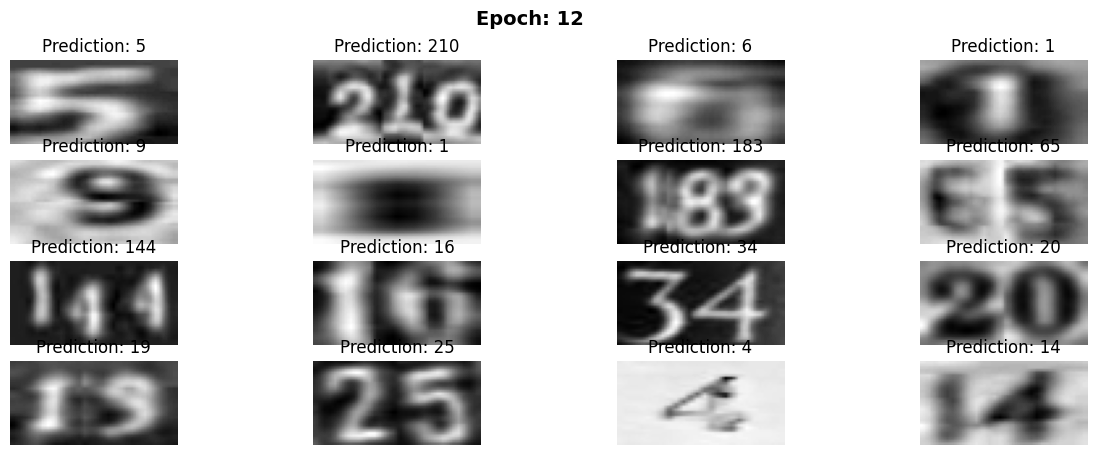

418/418 [==============================] - 26s 63ms/step - loss: 0.4136 - val_loss: 0.8142 - lr: 0.0010
Epoch 14/30
2/2 [==============================] - 1s 7ms/step - loss: 0.37


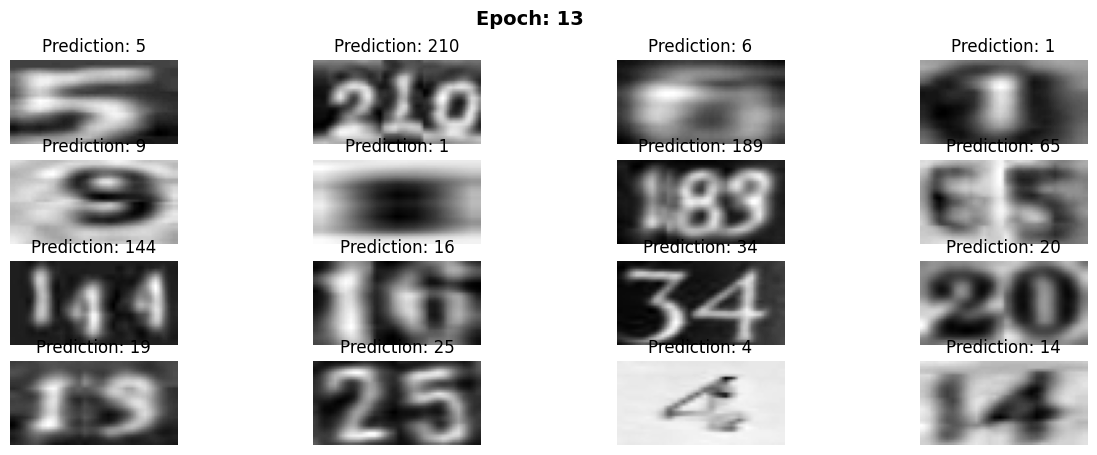

418/418 [==============================] - 25s 60ms/step - loss: 0.3782 - val_loss: 0.8160 - lr: 0.0010
Epoch 15/30
2/2 [==============================] - 1s 8ms/step - loss: 0.36


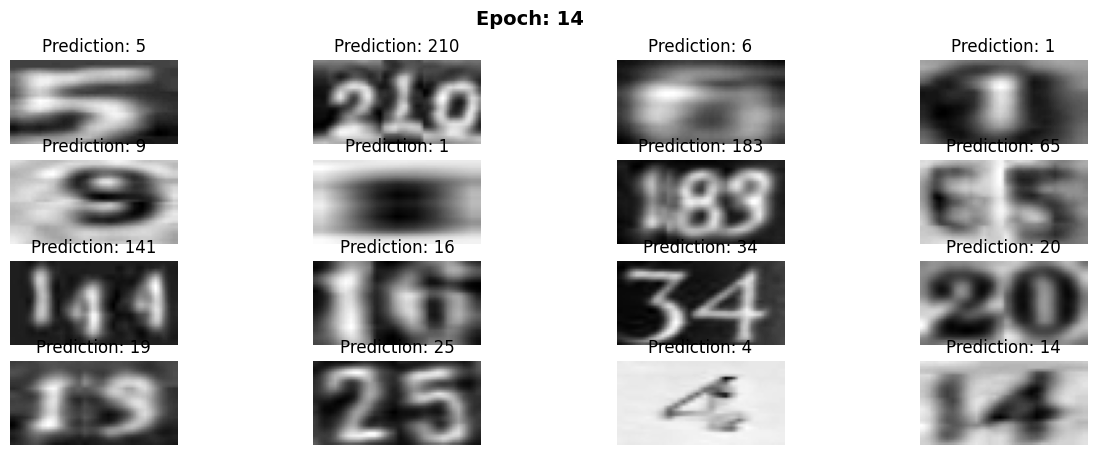


Epoch 15: ReduceLROnPlateau reducing learning rate to 0.000512000024318695.
418/418 [==============================] - 25s 60ms/step - loss: 0.3669 - val_loss: 0.7729 - lr: 0.0010
Epoch 16/30
2/2 [==============================] - 1s 8ms/step - loss: 0.27


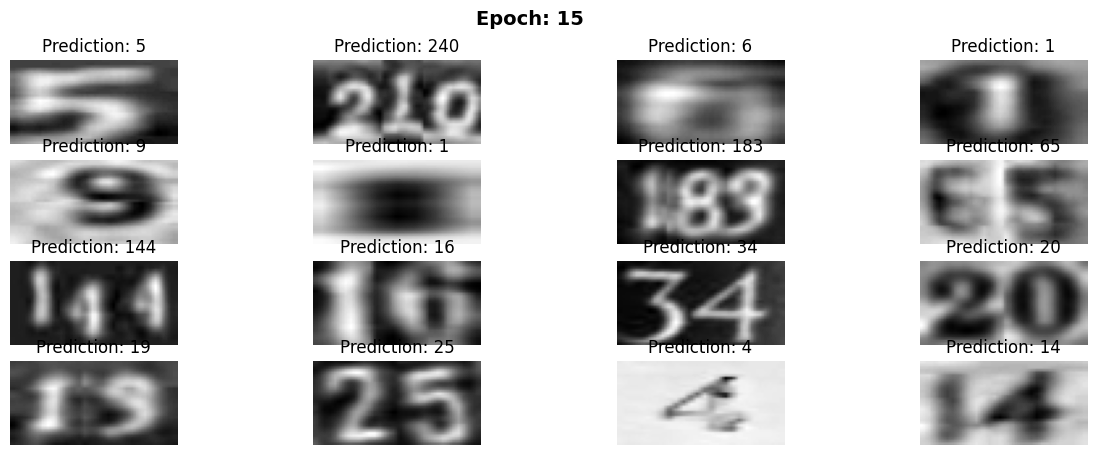

418/418 [==============================] - 25s 60ms/step - loss: 0.2767 - val_loss: 0.7785 - lr: 5.1200e-04
Epoch 17/30
2/2 [==============================] - 1s 8ms/step - loss: 0.22


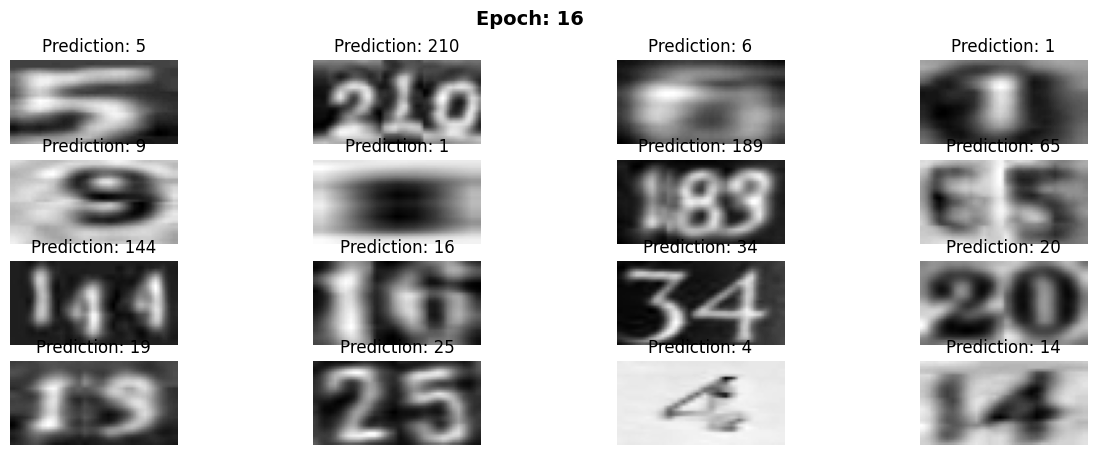

418/418 [==============================] - 25s 60ms/step - loss: 0.2265 - val_loss: 0.7714 - lr: 5.1200e-04
Epoch 18/30
2/2 [==============================] - 1s 8ms/step - loss: 0.20


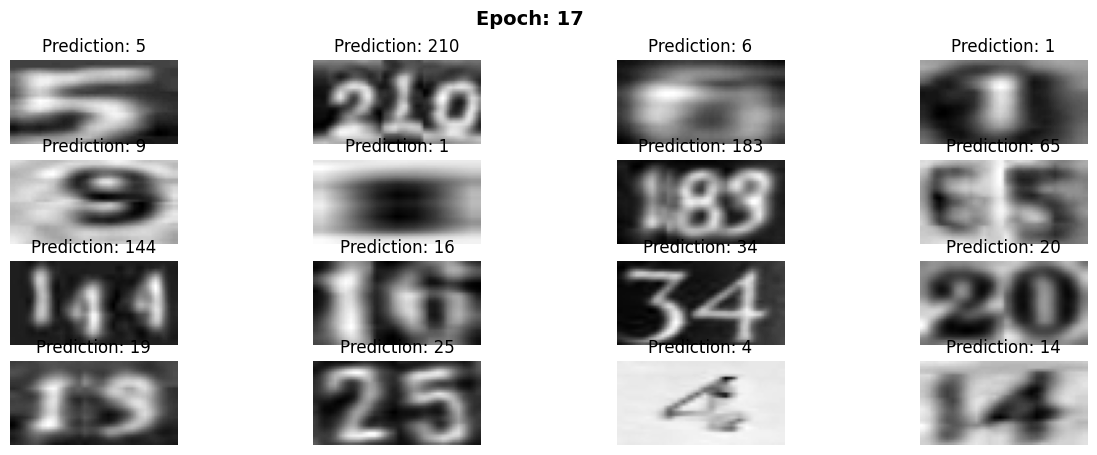

418/418 [==============================] - 25s 60ms/step - loss: 0.2003 - val_loss: 0.7804 - lr: 5.1200e-04
Epoch 19/30
2/2 [==============================] - 1s 7ms/step - loss: 0.18


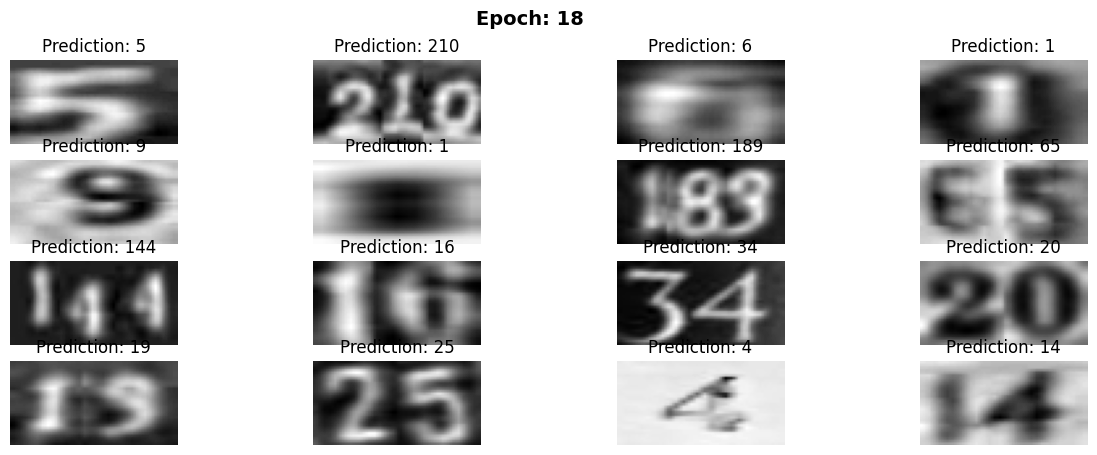


Epoch 19: ReduceLROnPlateau reducing learning rate to 0.00026214399933815005.
418/418 [==============================] - 25s 60ms/step - loss: 0.1898 - val_loss: 0.7843 - lr: 5.1200e-04
Epoch 20/30
2/2 [==============================] - 1s 8ms/step - loss: 0.14


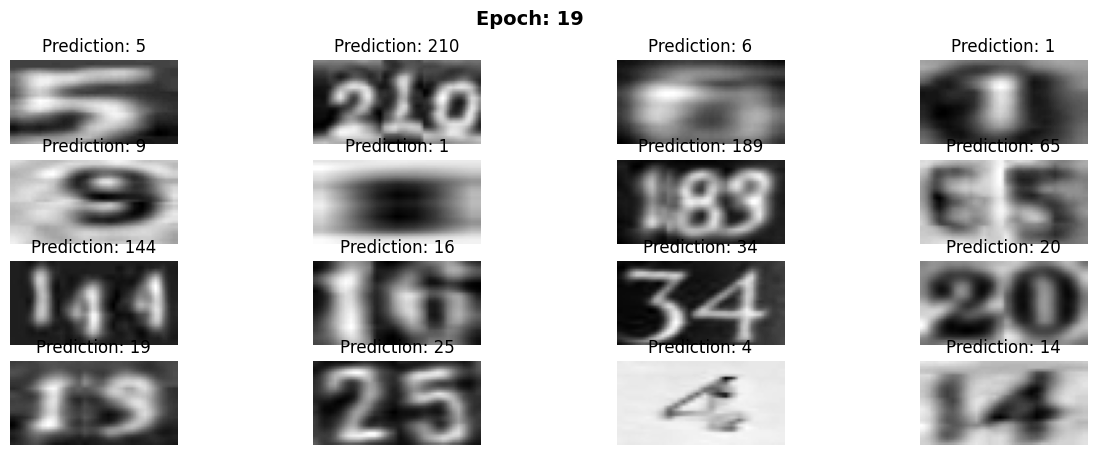

418/418 [==============================] - 25s 60ms/step - loss: 0.1453 - val_loss: 0.7604 - lr: 2.6214e-04
Epoch 21/30
2/2 [==============================] - 1s 7ms/step - loss: 0.12


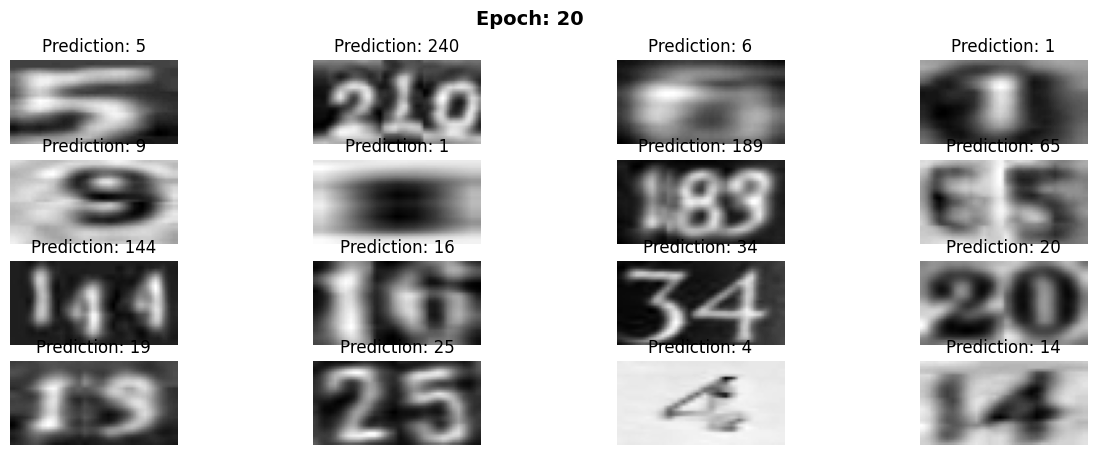

418/418 [==============================] - 25s 61ms/step - loss: 0.1231 - val_loss: 0.8057 - lr: 2.6214e-04
Epoch 22/30
2/2 [==============================] - 1s 8ms/step - loss: 0.11


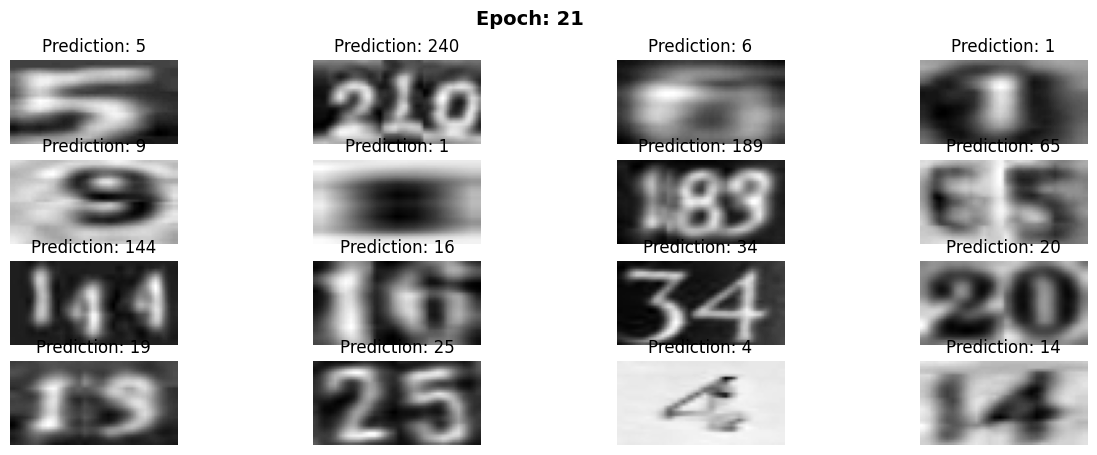

418/418 [==============================] - 25s 60ms/step - loss: 0.1112 - val_loss: 0.7996 - lr: 2.6214e-04
Epoch 23/30
2/2 [==============================] - 1s 7ms/step - loss: 0.10


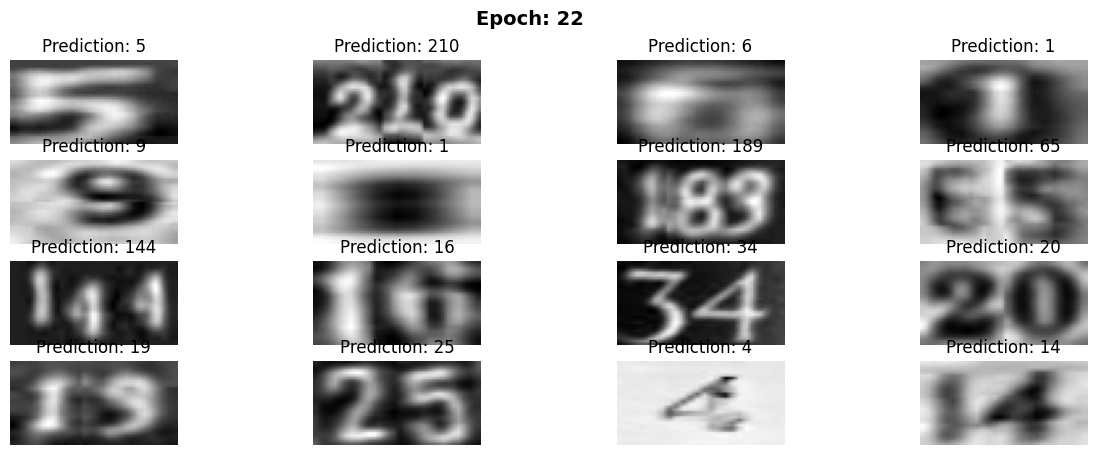


Epoch 23: ReduceLROnPlateau reducing learning rate to 0.00013421772420406342.
418/418 [==============================] - 25s 61ms/step - loss: 0.1000 - val_loss: 0.8409 - lr: 2.6214e-04
Epoch 24/30
2/2 [==============================] - 1s 8ms/step - loss: 0.08


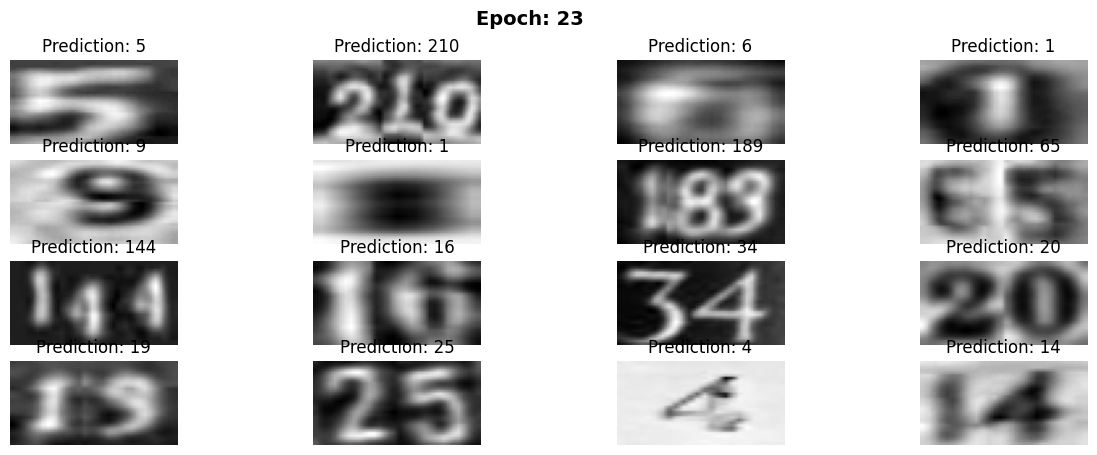

418/418 [==============================] - 25s 60ms/step - loss: 0.0827 - val_loss: 0.8412 - lr: 1.3422e-04
Epoch 25/30
2/2 [==============================] - 1s 7ms/step - loss: 0.07


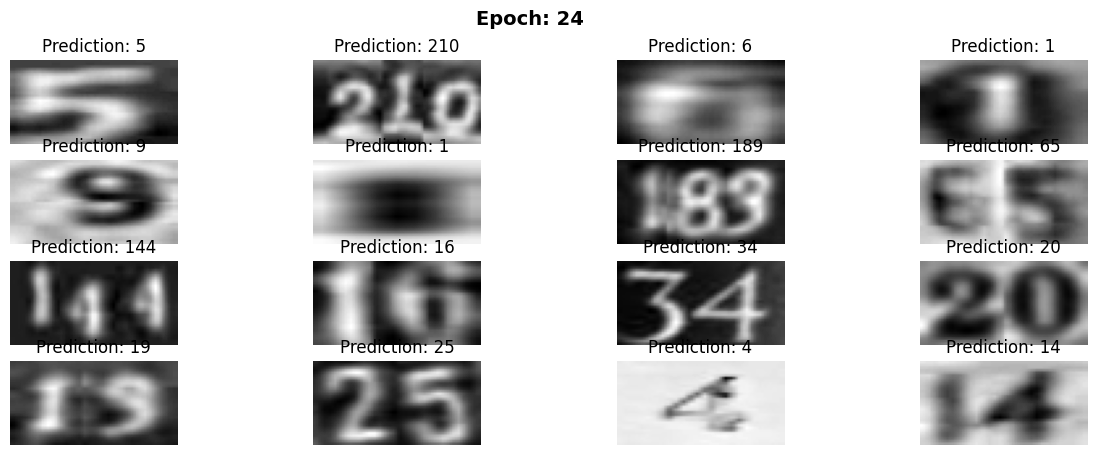

418/418 [==============================] - 27s 64ms/step - loss: 0.0710 - val_loss: 0.8494 - lr: 1.3422e-04
Epoch 26/30
2/2 [==============================] - 2s 7ms/step - loss: 0.06


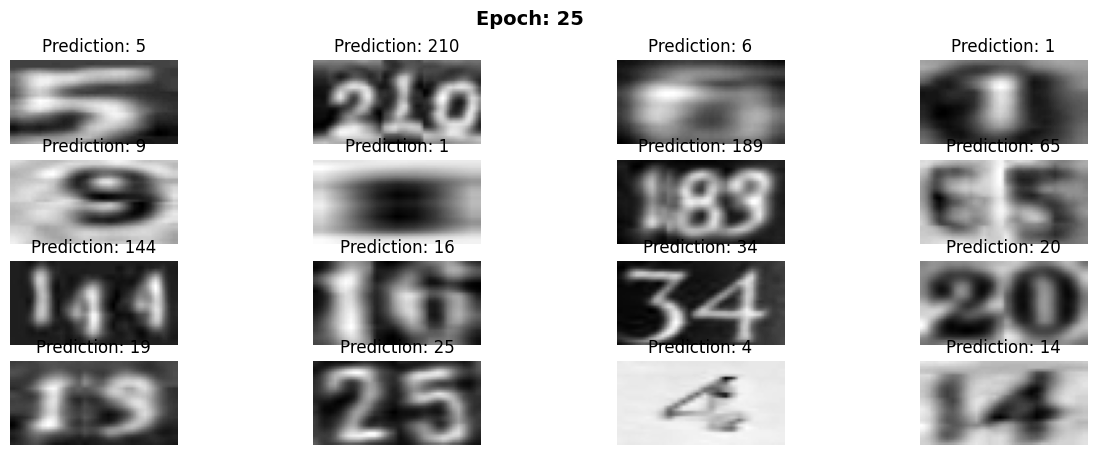

418/418 [==============================] - 26s 61ms/step - loss: 0.0640 - val_loss: 0.8836 - lr: 1.3422e-04
Epoch 27/30
2/2 [==============================] - 1s 8ms/step - loss: 0.06


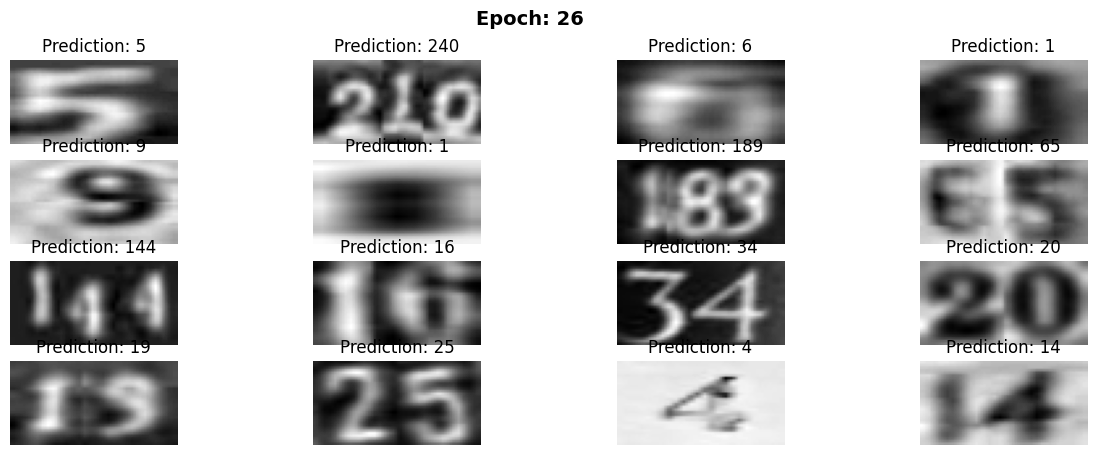


Epoch 27: ReduceLROnPlateau reducing learning rate to 6.871947646141052e-05.
418/418 [==============================] - 25s 61ms/step - loss: 0.0649 - val_loss: 0.8722 - lr: 1.3422e-04
Epoch 28/30
2/2 [==============================] - 1s 7ms/step - loss: 0.05


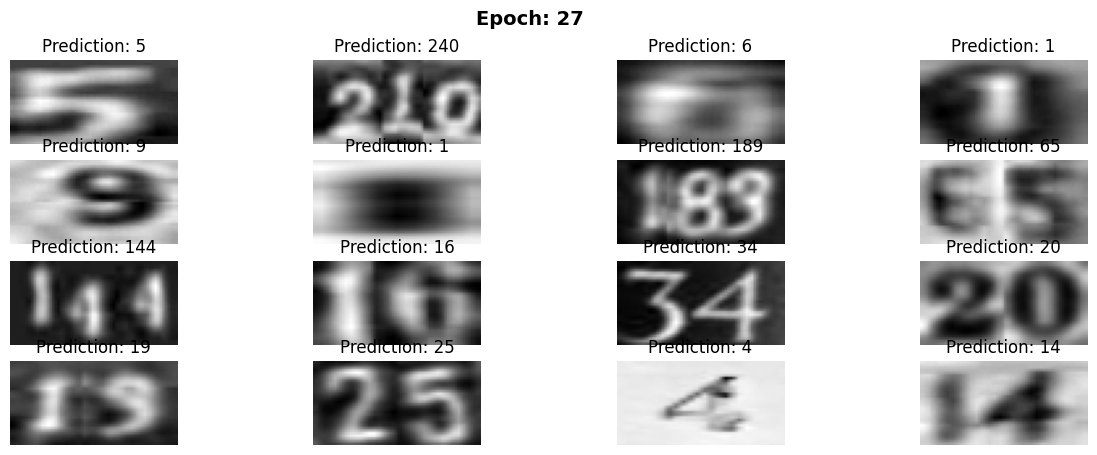

418/418 [==============================] - 25s 60ms/step - loss: 0.0518 - val_loss: 0.8949 - lr: 6.8719e-05
Epoch 29/30
2/2 [==============================] - 1s 7ms/step - loss: 0.05


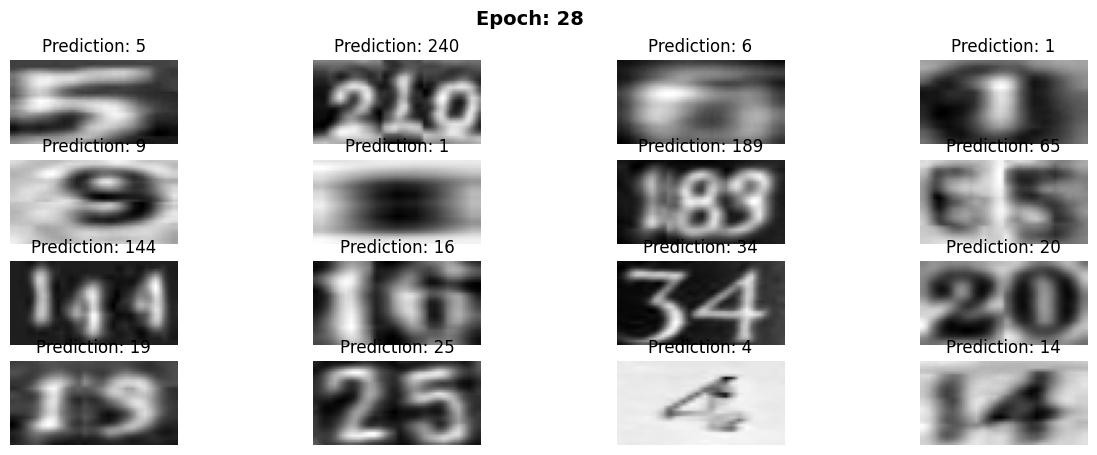

418/418 [==============================] - 25s 60ms/step - loss: 0.0507 - val_loss: 0.8798 - lr: 6.8719e-05
Epoch 30/30
2/2 [==============================] - 1s 7ms/step - loss: 0.04


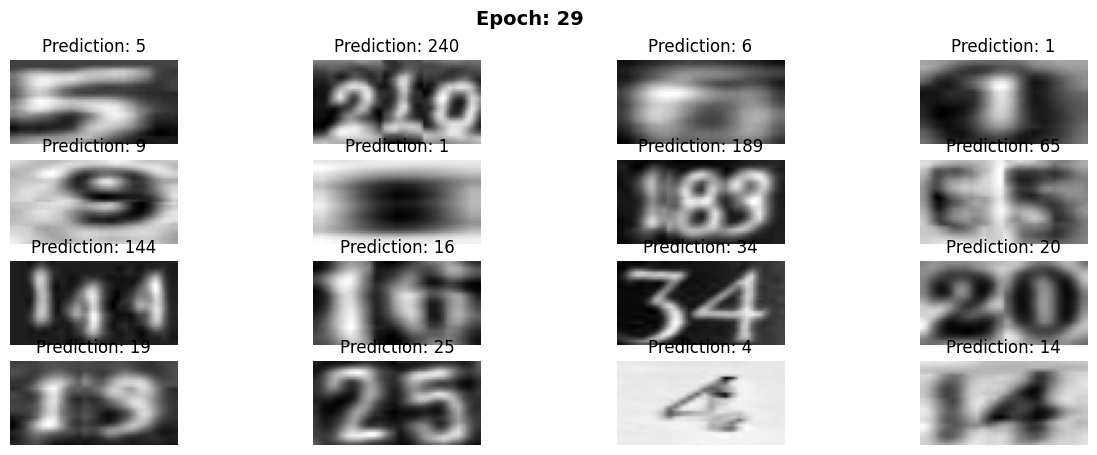

418/418 [==============================] - 25s 60ms/step - loss: 0.0471 - val_loss: 0.9014 - lr: 6.8719e-05


In [41]:
history = model.fit(train_dataset, 
                        epochs = 30,
                        validation_data=val_dataset,
                        callbacks = callbacks_list,
                        verbose = 1,
                        shuffle=True)

In [42]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, 
    model.get_layer(name="dense").output  # Replace with the correct name
)

In [43]:
# Initialize empty lists to store the images and labels
all_images = []
all_labels = []

# Iterate through the entire val_dataset to accumulate the images and labels
for batch in test_dataset:
    images = batch["image"]  # Access the image tensor for the current batch
    labels = batch["label"]  # Access the label tensor for the current batch

    all_images.append(images)  # Append the images to the list
    all_labels.append(labels)  # Append the labels to the list

# Convert the lists to NumPy arrays if needed
all_images = np.concatenate(all_images, axis=0)  # Concatenate the list of images into a single array
all_labels = np.concatenate(all_labels, axis=0)  # Concatenate the list of labels into a single array


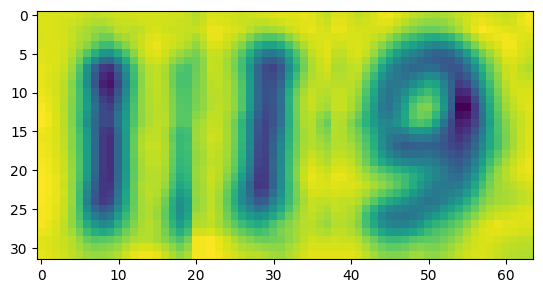

In [44]:
plt.imshow(all_images[1000])

In [45]:
all_labels[1000]

array([ 1,  1,  9, 10, 10, 10], dtype=int32)

In [46]:
import random

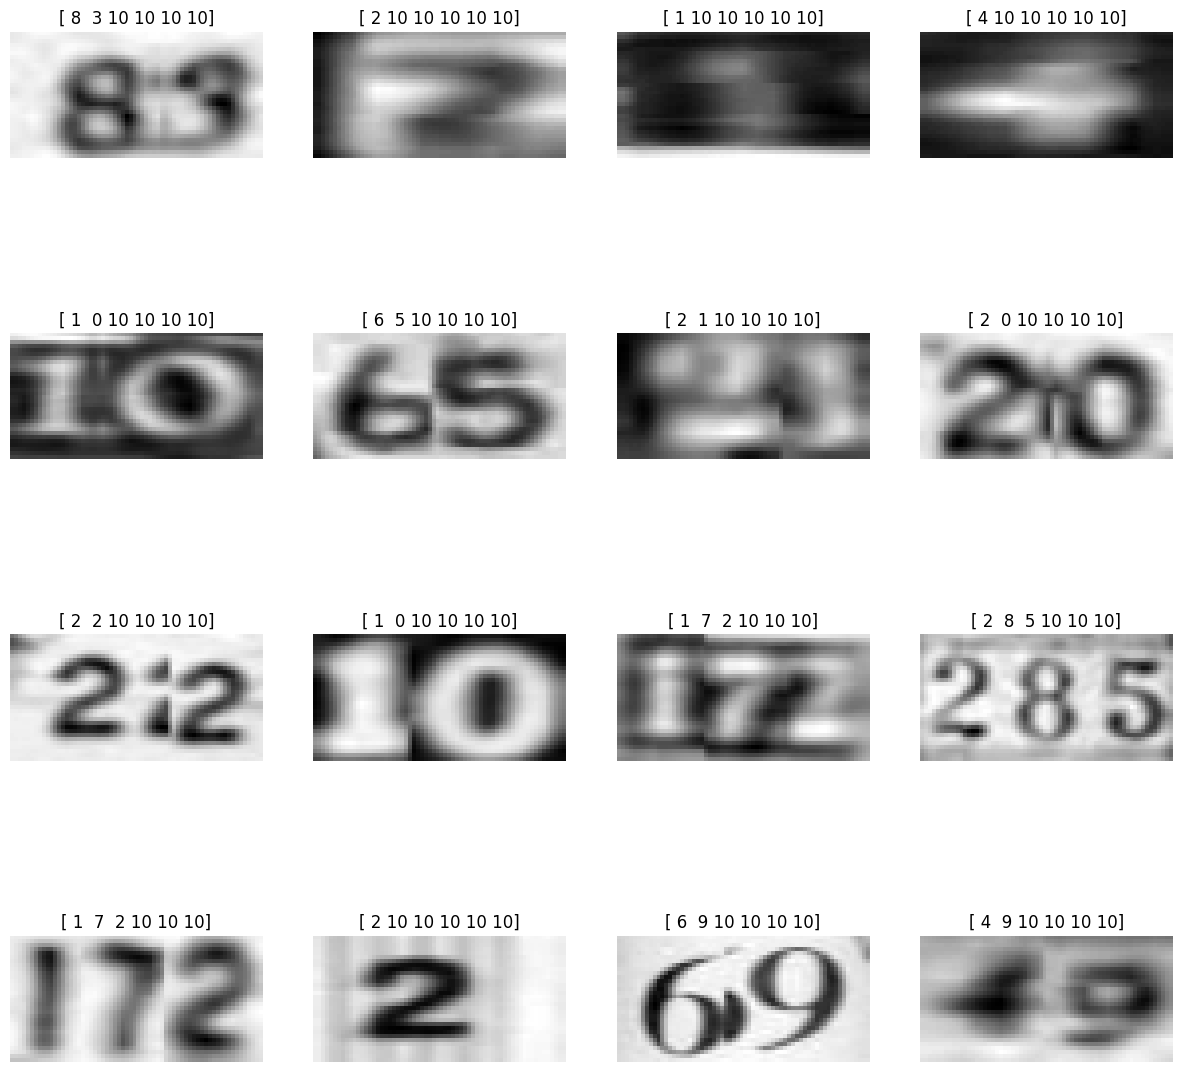

In [47]:
plt.figure(figsize=(15,15))
for i in range(16):
    ran =random.randint(0,len(all_images))
    plt.subplot(4,4,i+1)
    plt.imshow(all_images[ran] ,cmap="gray")
    plt.axis("off")
    plt.title(all_labels[ran])

In [48]:
print(ctc_accuracy(prediction_model(all_images[:10000]) , all_labels[:10000]))

CTC Accuracy: 0.8634
None
